<a href="https://colab.research.google.com/github/AnhVanGiang/MO/blob/main/agg350_Second_assignment_Mathematical_optimization_2022_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second assigment - Mathematical Optimization 2022-2023
The second assignment consists of three parts. The first part concerns the implementation of a elastic net regression method as a convex program. The second part asks you to solve a wind turbine placement problem using stochastic programming. The third part requires you to implement a chance-constrained problem in the context of renewable energy sources. Each part gives a total of 30 points and the final assignment grade is determined by `(# points / 90) * 9 + 1`.


## Setup
We import here all libraries and solvers needed for the entire assignment. Make sure to use `ipopt` for solving convex programs and `gurobi` for solving mixed-integer linear programs.

In [1]:
import httpimport

with httpimport.github_repo('alessandrozocca', 'MO2022', 'helpers'):
    from helpers import installer    

    if installer.on_colab():
        installer.install_pyomo()
        installer.install_ipopt()
        installer.install_gurobi()

    from helpers.assignment2 import read_elastic_net_data, generate_wind_farm_data, plot_wind_farm, read_economic_dispatch_data

Installing pyomo from idaes_pse via pip ... installation successful
Installing ipopt and k_aug on Google Colab via idaes get-extensions ... installation successful
Installing gurobi on Google Colab via pip ... installation successful


In [2]:
import requests
import time

from IPython.display import Markdown, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyomo.environ as pyo

%matplotlib inline 

# Part 1: Elastic net (30 points)

Suppose we have a finite dataset consisting of $n$ points $\{({X}^{(i)}, y^{(i)})\}_{i=1,\dots,n}$ with ${X}^{(i)} \in \mathbb{R}^k$ and $y^{(i)} \in \mathbb{R}$. Consider least-square error linear regression with two regularizing terms, that is

$$
\min_\beta \frac{1}{2n} \lVert y – X \beta \rVert_2^2 + \alpha \cdot ( \lambda \lVert \beta \rVert_1 + \frac{1}{2} (1-\lambda) \lVert \beta \rVert_2^2 ),
$$ 

with $\lambda \in [0,1]$ and $\alpha \in [0.25, 1.75]$. This regression method is known as the [elastic net](https://en.wikipedia.org/wiki/Elastic_net_regularization), which combines the $L_1$ (Lasso) and $L_2$ (Ridge) regression methods. 

## Data
For this part of the assignment, we import a simple data set on wind speed realizations. The `X` variable contains the features and the `y` variables corresponds to the realized wind speed.

In [3]:
X, y = read_elastic_net_data()

## Solver
`ipopt` should be used in this part of the assignment:

In [4]:
ipopt_solver = pyo.SolverFactory('ipopt')

## Questions part 1
**Important:** For this part of the assignment, you are allowed to use the companion notebook on [Ordinary Least Squares regression](https://mobook.github.io/MO-book/notebooks/05/ols-regression.html).

  1. [10 pts] Consider the regularizing term in isolation, that is $$\lambda \lVert \beta \rVert_1 + \frac{1}{2} (1-\lambda) \lVert \beta \rVert_2^2.$$ Is this term always a convex function of $\beta$ or does it depend on the value of the coefficient $\lambda$? Is this term always a *strictly* convex function of $\beta$ or does it depend on the value of the coefficient $\lambda$?

  2. [15 pts] Implement a ```pyomo``` concrete model that takes $\alpha$, $\lambda$ and a dataset $(X,y)$ and builds the elastic net model. Solve the model you built to return the results for Lasso ($\lambda = 1$) and Ridge ($\lambda = 0$) regularization with $\alpha = 1$, using the data set above (contained in the `X`, `y` variables). The results should include the objective value and the solution $\beta$. Comment on the differences of the two vectors of regressors $\beta$’s returned by the two models.

  3. [5 pts] Assume that $\lambda$ is now a variable instead of a parameter. In other words, the optimization problem that we try to solve is $$
\min_{\beta \in \mathbb{R}^k,\lambda \in [0, 1]} \frac{1}{2n} \lVert y – X \beta \rVert_2^2 + \alpha \cdot ( \lambda \lVert \beta \rVert_1 + \frac{1}{2} (1-\lambda) \lVert \beta \rVert_2^2 ),$$ with $\alpha \in [0, 1]$. Can we find the optimal $\lambda$ by solving the model as convex optimization problem? Explain your answer. You do not have to implement this model.

### Question 1.1

For the function to be convex, it requires both $f_1 = \lambda \lVert \beta \rVert_1$ and $f_2 = \frac{1}{2} (1 - \lambda)\lVert \beta \rVert_2$ to be convex (one can easily plot and check otherwise). First let check $f_1$, we have that $f_1 = \lambda \lVert \beta \rVert_1$ with $\lVert \beta \rVert_1$ convex so for $f_1$ to be convex, it follows that $\lambda \lVert \xi v + (1 - \xi) w \rVert_1 \leq \lambda (\xi \lVert v \lVert_1 + (1 - \xi) \lVert v \rVert_1)$ for $\lVert \xi v + (1 - \xi) w \rVert_1 \leq (\xi \lVert v \lVert_1 + (1 - \xi) \lVert v \rVert_1)$ with $\xi \in [0,1]$ and $v,w \in \mathbb{R}^k$. This hold if $\lambda \geq 0$. Do the same thing for $f_2 = \frac{1}{2} (1 - \lambda)\lVert \beta \rVert_2$, we need $1 - \lambda > 0$ or $\lambda \leq 1$. Thus, for the function to be convex, we need $\lambda \in [0,1]$. Since a function is strictly convex then it is convex, it follows that the strict convexity of the function depends on $\lambda$ as well.  

### Question 1.2

In [5]:
def elastic_net(alpha, lam, X, y):
    
    n, k = X.shape

    model = pyo.ConcreteModel()

    model.rowind = pyo.Set(initialize=range(n))
    model.colind = pyo.Set(initialize=range(k))

    model.xp = pyo.Var(model.colind, domain=pyo.PositiveReals)
    model.xm = pyo.Var(model.colind, domain=pyo.PositiveReals)

    @model.Objective(sense=pyo.minimize)
    def objective(model):
      return 1/(2*n) * sum((y[i] - sum(X[i, j] * (model.xp[j] - model.xm[j]) for j in model.colind))**2 for i in model.rowind) + \
      alpha * (lam * sum((model.xp[j] + model.xm[j]) for j in model.colind) + 1/2 * (1 - lam) * sum((model.xp[j] - model.xm[j])**2 for j in model.colind))

    return model 

In [6]:
lasso_model = elastic_net(1, 1, X, y)
result = ipopt_solver.solve(lasso_model)
objective, betas = lasso_model.objective(), [lasso_model.xp[j]() - lasso_model.xm[j]() for j in range(len(lasso_model.xm))]
print(objective, betas)

20.779638448210335 [9.919363068543326e-09, 0.2835834052747683, 0.0, 0.6364818936426365, 0.0, 0.0, -0.22995997377737531]


In [7]:
ridge_model = elastic_net(1, 0, X, y) 
result = ipopt_solver.solve(ridge_model)
objective, betas = ridge_model.objective(), [ridge_model.xp[j]() - ridge_model.xm[j]() for j in range(len(lasso_model.xm))]
print(objective, betas)

19.695331342060282 [0.28262422190843234, 0.32625034110037415, 0.04449235970444548, 0.5683956122895611, 0.17014641323171176, 0.16923015792155333, -0.3384860482921063]


The Lasso regularization results in multiple 0 values of $\beta$ as opposed to the Ridge one because Lasso regularization is often used in feature selections thus features that are deemed non-important are regularized to 0. 

### Question 1.3

It is possible to find optimal $\lambda$ by solving the model as a convex optimization problem and constraint $\lambda \in [0,1]$. Because for $\lambda \in [0,1]$ the problem is still convex and thus, a minimum exists. Also, I have implemented a model for the scenario and it is indeed solvable.

# Part 2: Stochastic wind turbine placement (30 points)

To reduce human impact on the enviroment we need to, among other things, adopt sustainable energy solutions as much as we can. In the second part of the assignment, your task is to optimize the design of an offshore wind farm by deciding both the number of turbines to place and their location in order to maximize the *expected annual energy production*. 

<img style="float: center" width="42%" src="https://www.azocleantech.com/images/Article_Images/ImageForArticle_1072_15838579104765310.png">
<img style="float: center" width="50.5%" src="https://images-global.nhst.tech/image/UVowQXJqcWJ1SGRkWG5na01OeUU3MitmcGdpbXVxVnBNdmRlY3dEZUFSaz0=/nhst/binary/54ac8d5f8f2568024e60e932a476bf60">

## Problem description

Wind turbines convert wind energy to electricity. Past wind speed and angles observations and the characteristics of the turbine chosen are used to convert the wind measurements into the wind energy production, if placed on a specific site. 

Every turbine affects the performance of the other turbines nearby. More specifically, there will be a **wake** behind each turbine, a long trail of wind which is quite turbulent and slowed down (see figure above). This is the so-called [wake effect](http://xn--drmstrre-64ad.dk/wp-content/wind/miller/windpower%20web/en/tour/wres/wake.htm). The interference caused by each possible turbine site on each other possible turbine site translates into losses of wind energy production. 



## The deterministic MILP

Consider the following MILP that aims to find the best wind turbine placement problem while accounting for the intereference between turbines due to the wake effect:

$$
\begin{array}{llrl}
\max & \sum_{i \in V} P x_i- \ell_i \\
\, \mbox{ s.t.} & \sum_{i \in V} x_i \geq \nu,\\
& \sum_{i \in V} x_i \leq \mu,\\
& x_i + x_j \leq 1, & \forall i, j : d(i,j) \leq \delta, \\ 
& \sum_{j \in V, i \neq j,} I_{ij} x_j \leq \ell_i + M_i(1-x_i),  & \forall i \in V,\\
& x_i \in \{ 0, 1 \}, & \forall i \in V,\\
& \ell_i \geq 0, & \forall i \in V.\\
\end{array}
$$

The parameters of the model are:
 * $V$ is the collection of sites where the turbines could be placed, obtained as regularly distanced points on a $6\times 6$ grid. 
 * $P$ is the nominal energy production of a turbine without wake effects. We assume all turbines are identical and would thus produce the same nominal energy.
 * $I_{ij}$ is the interference (loss of energy production) caused by a turbine placed at $j$ on a turbine placed at $i$.
 * $\nu$ is the minimum number of turbines to be placed.
 * $\mu$ is the maximum number of turbines to be placed.
 * $\delta$ is a minimum feasible distance and $d(i, j)$ is the Euclidean distance between two sites.

The decision variables of the model are:
 * $x_i \in \{0,1\}$ describes whether or not a wind turbine is placed at site $i\in V$
 * $\ell_i \geq 0$ describes the lost wind energy production for the turbine at site $i$ due to the combined wake effect of all the other turbines that have been placed.

The objective of the model is to maximize the sum of the nominal energy production of the placed turbines minus the total lost energy production due the interference experienced by the placed turbines.

The constraints of the model are:
- The 1st constraint sets a lower bound for the number of turbines to be placed.
- The 2nd constraints sets a upper bound for the number of turbines to be placed.
- The 3rd consraint ensures that two wind turbines can only be placed in two sites if these are at Euclidean distance $d(\cdot,\cdot)$ at least $\delta$ from each other.
- The 4th constraint calculate the lost wind energy production $\ell_i$ that turbine $i$ may experience, if placed. In particular, if turbine $i$ is not placed (i.e. $x_i=0$), then no interference should be experienced by that turbine (i.e. $\ell_i=0$). On the other hand, we want to make sure that if a turbine is placed (i.e. $x_i=1$), then the interference on turbine $i$ should be exactly equal to the cumulative sum of the interferences $I_{ij}$ due to all other turbines $j$ that are placed. The valid value of big-M constants $M_i$ have been already pre-determined for you given the other parameters of the model are fixed.

Below you can find the Pyomo implementation of the above MILP.

In [8]:
def wind_farm_model(
    n_sites, coords, production, min_distance, min_turbines, max_turbines, interference_matrix, **kwargs
):
    model = pyo.ConcreteModel()

    model.sites = pyo.Set(initialize=range(n_sites))
    model.M = pyo.Param(model.sites, initialize=interference_matrix.sum())

    model.turbine = pyo.Var(model.sites, domain=pyo.Binary, doc="x")
    model.wake = pyo.Var(model.sites, domain=pyo.NonNegativeReals, doc="l")

    @model.Objective(sense=pyo.maximize)
    def objective(m):
        return sum(production * m.turbine[i] - m.wake[i] for i in m.sites)

    @model.Constraint()
    def minimum_number_turbines(m):
        return sum(m.turbine[i] for i in m.sites) >= min_turbines

    @model.Constraint()
    def maximum_number_turbines(m):
        return sum(m.turbine[i] for i in m.sites) <= max_turbines

    @model.Constraint(model.sites, model.sites)
    def avoid_close_turbine_placement(m, i, j):
        distance = np.linalg.norm(coords[i] - coords[j])
        
        if i != j and distance < min_distance:
            return m.turbine[i] + m.turbine[j] <= 1
        else:
            return pyo.Constraint.Skip

    @model.Constraint(model.sites)
    def interference(m, i):
        total_interference = sum(interference_matrix[i, j] * m.turbine[j] for j in m.sites if i != j)
        activation = m.wake[i] + m.M[i] * (1 - m.turbine[i])
        return total_interference <= activation

    return model

## Uncertainty
The entries of interference matrix $I_{ij}$ are calculated using both the relative distance of sites $i$ and $j$, as well as how they are placed with respect to a specific wind realization. It is intuitive that if the wind has a different direction or a different speed, then the interference matrix $I$ will also be different.

## Problem data

In [9]:
instance, interference_matrices = generate_wind_farm_data()

The function `generate_wind_farm_data()` generates both an instance of the placement problem importing all the parameters above as well as a collection of 45 different interference matrices corresponding to 45 different wind scenarios.

The `instance` variable is a dictionary that contains the following key-value pairs:
- `n_sites`: the number of sites
- `coords`: the coordinates for each site
- `production`: the wind energy production for turbine
- `min_distance`: the minimum distance between two sites
- `min_turbines`: the minimum number of turbines to be placed
- `max_turbines`: the maximum number of turbines to be placed.

Each site is indexed, which can be used to access its coordinates (see figure below).

A solution to the instance can be plotted using the `plot_wind_farm` function:

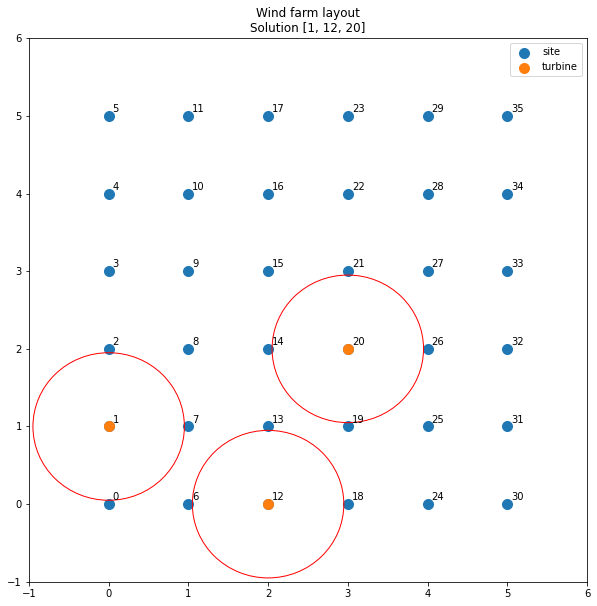

In [10]:
plot_wind_farm(instance, solution=[1, 12, 20])

## Solver
The wind farm optimization model is quite complex and `cbc` is unable to solve the MILP in a reasonable time. You should therefore use the `gurobi` solver:

In [11]:
gurobi_solver = pyo.SolverFactory('gurobi')

However, this is a "free" Gurobi version which only solves your model if it has less than 2000 variables and 2000 constraints. If you follow all steps correctly, it is possible to make a model that is small enough to be solved by Gurobi. If your model is too large, then the Gurobi solver will complain and you will need to make your model more compact.

## Questions part 2

1. [5 pts] For the provided 45 wind scenarios, solve the determinsitic MILP using the corresponding interference matrix and calculate the corresponding wind energy production. Calculate the average wind energy production $E_\mathrm{PI}$ over these 45 wind scenarios.

*Consider using the provided plot function to visualize the optimal wind turbine placements in a few different scenarios and check that is not always identical!*

2. [15 pts] Consider now a stochastic version of wind turbine placement problem which we will solve using the Sample Average Approximation (SAA) method. Write down the full mathematical model (i.e. the extensive form that the SAA method implicitly defines), then implement it in ```pyomo```, and solve it. Report the resulting optimal value, denoted by $E_\mathrm{SAA}$, and plot the optimal turbine placement $x^*_\mathrm{SAA}$.

3. [10 pts] Compare the quantities $E_\mathrm{PI}$ and $E_\mathrm{SAA}$. Which one is higher? Explain why. Was this to be expected?

### Question 2.1


The wind productions for each interference matrix and the average are shown below.

In [12]:
l = []
for i in range(interference_matrices.shape[0]):
  model = wind_farm_model(instance["n_sites"], 
                          instance["coords"],
                          instance["production"],
                          instance["min_distance"],
                          instance["min_turbines"],
                          instance["max_turbines"],
                          interference_matrices[i])
  gurobi_solver.solve(model)
  print(f"Wind production of interference matrix {i + 1} is {model.objective()}")
  l.append(model.objective())

print(f"Average wind product across all interference matrices: {np.mean(l)}")


Wind production of interference matrix 1 is 849.342623091932
Wind production of interference matrix 2 is 400.8751928149802
Wind production of interference matrix 3 is 536.4113207526127
Wind production of interference matrix 4 is 703.0049259491975
Wind production of interference matrix 5 is 900.0
Wind production of interference matrix 6 is 900.0
Wind production of interference matrix 7 is 692.7308735771892
Wind production of interference matrix 8 is 685.7237242577443
Wind production of interference matrix 9 is 417.3065277228891
Wind production of interference matrix 10 is 900.0
Wind production of interference matrix 11 is 900.0
Wind production of interference matrix 12 is 451.4684020188357
Wind production of interference matrix 13 is 356.2732392263625
Wind production of interference matrix 14 is 900.0
Wind production of interference matrix 15 is 900.0
Wind production of interference matrix 16 is 900.0
Wind production of interference matrix 17 is 716.6533102494399
Wind production of inte

### Question 2.2

Using SAA, we can convert the initial problem into a two-stage problem then extend it as 

$$
\begin{array}{llrl}
\max & \sum_{i \in V}(P x_i- \frac{1}{45} \sum_{s=1}^{45} \ell_{i}^{s}) \\
\, \mbox{ s.t.} & \sum_{i \in V} x_i \geq \nu,\\
& \sum_{i \in V} x_i \leq \mu,\\
& x_i + x_j \leq 1, & \forall i, j : d(i,j) \leq \delta, \\ 
& \sum_{j \in V, i \neq j,} I_{ij}^{s} x_j \leq \ell_i^{s} + M_i(1-x_i),  & \forall i \in V \; \forall s \in \{1,2,\dots,45\} ,\\
& x_i \in \{ 0, 1 \}, & \forall i \in V,\\
& \ell_i \geq 0, & \forall i \in V.\\
\end{array}
$$



In [27]:
def wind_farm_model_saa(
    n_sites, coords, production, min_distance, min_turbines, max_turbines, 
    interference_matrices, **kwargs
):
    model = pyo.ConcreteModel()

    N = len(interference_matrices)

    model.sites = pyo.Set(initialize=range(n_sites))
    model.indices = pyo.Set(initialize=range(N))

    model.M = pyo.Param(model.sites, model.indices,
                        initialize=interference_matrices.sum())

    model.turbine = pyo.Var(model.sites, domain=pyo.Binary, doc="x")
    model.wake = pyo.Var(model.sites, model.indices, 
                         domain=pyo.NonNegativeReals, doc="l")
    

    @model.Expression()
    def first_stage_obj(model):
      return sum(production * model.turbine[i] for i in model.sites)

    @model.Expression()
    def second_stage_obj(model):
      return -1/45 * sum(sum(model.wake[i, s] for s in model.indices) for i in model.sites)

    @model.Objective(sense=pyo.maximize)
    def objective(model):
        return model.first_stage_obj + model.second_stage_obj

    @model.Constraint()
    def minimum_number_turbines(m):
        return sum(m.turbine[i] for i in m.sites) >= min_turbines

    @model.Constraint()
    def maximum_number_turbines(m):
        return sum(m.turbine[i] for i in m.sites) <= max_turbines

    @model.Constraint(model.sites, model.sites)
    def avoid_close_turbine_placement(m, i, j):
        distance = np.linalg.norm(coords[i] - coords[j])
        
        if i != j and distance < min_distance:
            return m.turbine[i] + m.turbine[j] <= 1
        else:
            return pyo.Constraint.Skip

    @model.Constraint(model.sites, model.indices)
    def interference(m, i, s):
        total_interference = sum(interference_matrices[s, i, j] * m.turbine[j] for j in m.sites if i != j)
        activation = m.wake[i, s] + m.M[i, s] * (1 - m.turbine[i])
        return total_interference <= activation

    return model

In [28]:
saa_model = wind_farm_model_saa(instance["n_sites"], 
                          instance["coords"],
                          instance["production"],
                          instance["min_distance"],
                          instance["min_turbines"],
                          instance["max_turbines"],
                          interference_matrices)
gurobi_solver.solve(saa_model)

{'Problem': [{'Name': 'x1657', 'Lower bound': 570.7524750970966, 'Upper bound': 570.7524750970966, 'Number of objectives': 1, 'Number of constraints': 1843, 'Number of variables': 1657, 'Number of binary variables': 36, 'Number of integer variables': 36, 'Number of continuous variables': 1621, 'Number of nonzeros': 21393, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '12.407145023345947', 'Error rc': 0, 'Time': 12.485573530197144}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

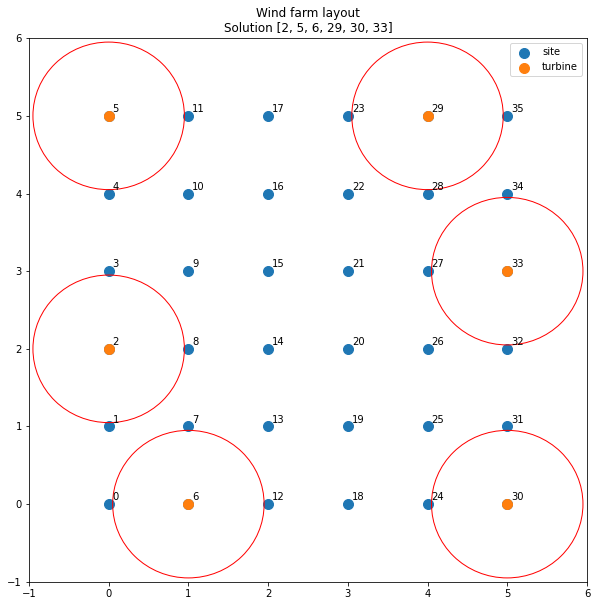

In [29]:
slst = [i for i in saa_model.turbine if saa_model.turbine[i]() == 1]
plot_wind_farm(instance, slst)

In [30]:
print(f"SAA Model production: {saa_model.objective()}")

SAA Model production: 570.7524750970967


### Question 2.3

It can be seen that $E_{PI} > E_{SAA}$ because the number of samples that we take for the interference matrix is too small (45) compared to the dimension or the number of sites (36) thus runs the risk of overfitting.

# Part 3: Economic dispatch (30 points)
The _economic dispatch (ED)_ problem is the short-term determination of the optimal production of energy to meet all energy demand. Let $V$ denote a set of nodes each of which is representing cities, industrial districts, or power generators or combinations of these. Each node $i \in V$ **may** have:
- a certain energy demand $d_i \geq 0$; 
- a power generator whose energy production needs to be between $p_i^\min$ and $p_i^{\max}$ units of power. The cost of production one unit of power at node $i$ is given by a variable cost $c_i > 0$. 

Not all the nodes have both demand and generation, more specifically it is possible for a node to have only generation or only demand.

The goal is to determine for each node $i \in V$ the optimal production level $p_i$, such that the total energy demand is met, no production limits are exceeded, and the total energy production costs are minimized. We can formulate the problem as the following MILP:

\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V} c_i p_i\\
\mbox{s.t.} & \sum_{i \in V} p_i = \sum_{i \in V} d_i,\\
& p_{i}^{\min } \leq p_{i} \leq p_{i}^{\max } & \forall i \in V.
\end{array}
\end{align}

Now assume that we have built several off-shore wind turbines. These wind turbines combined together produce a random nonnegative amount of extra energy, denoted by $\omega$.

\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V} c_i p_i\\
\mbox{s.t.} & \omega + \sum_{i \in V} p_i = \sum_{i \in V} d_i,\\
& p_{i}^{\min } \leq p_{i} \leq p_{i}^{\max } & \forall i \in V.
\end{array}
\end{align}

Because of stochastic fluctuations in wind power generation, the ED problem is best modeled as a stochastic optimization problem. The intermittency of wind generation makes it almost impossible to perfectly balance supply and demand, but in practice there is some room for error. We denote by
- $\Delta \geq 0$ the tolerance of the absolute power difference between supply and demand;
- $\varepsilon \in [0,1]$ is the risk level we are willing to accept for the supply to deviate from the demand more than $\Delta$;
- $\omega \in \mathbb{R}_{\geq 0}$ the nonnegative random variable describing the total power production of off-shore wind turbines.

Instead of requiring that the supply and demand are matched perfectly, we require that the absolute difference remains below power threshold $\Delta$ using the following chance constraint:
\begin{align}
  \mathbb{P} \Big ( \Big | \omega + \sum_{i \in V } p_i  - \sum_{i \in V} d_i \Big | \leq \Delta \Big) \geq 1 - \varepsilon
\end{align}

Breaking this up (hence "relaxing" it) into two individual chance constraints, this leads to the following optimization problem with chance constraints:

\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V } c_i(p_i)\\
\mbox{s.t.} & \mathbb{P}(\omega + \sum_{i \in V } p_i  - \sum_{i \in V} d_i \leq \Delta) \geq 1 - ɛ\\
& \mathbb{P}(\omega + \sum_{i \in V } p_i  - \sum_{i \in V} d_i \geq -\Delta) \geq 1 - ɛ\\
& p_{i}^{\min } \leq p_{i} \leq p_{i}^{\max } & \forall i \in V.
\end{array}
\end{align}

The goal of this part of the assignment is to implement this chance-constrained model.

### Data

In [ ]:
nodes, wind_production_samples = read_economic_dispatch_data()

For the third part of the assignment, we have a `nodes` dictionary, containing for every $i \in V$ information about $p_\min$, $p_\max$, $c_i$, $d_i$. Although not relevant for this assignment, there is a clear distinction in the data between nodes that only demand power, and nodes that only produce power.

In [ ]:
nodes[0]

The wind production samples can be accessed through the `wind_production_samples` variable. It is a list of 500 equiprobable outcomes for the wind generation.

In [ ]:
wind_production_samples[4] # fifth outcome

## Questions for part 3

We estimate the wind power production using historical data. You are given 500 outcomes of the total wind producton ```wind_production_samples```, all equiprobable (some outcomes are repeated, but you can treat them as different if you stick with the equal probability assumption).

1. [10 pts] Rewrite the chance-constrained ED problem for a generic tolerance $\Delta$ and risk level $\varepsilon \in [0,1]$ using the exact MILP reformulation. Write explicitly the mathematical MILP model and comment on it, explaining among other things the variables that you introduce.
2. [10 pts] Implement the MILP in ```pyomo```. Solve the model for the provided instance and wind production outcomes, and report the optimal objective value you obtain for $\varepsilon = 0.02$ and $\Delta=1000$.
3. [10 pts] Solve the same MILP varying the values first of $\varepsilon \in [0, 1]$ (for fixed $\Delta=1000$) and then of $\Delta \in [0, 2000]$ (for fixed $\varepsilon = 0.02$). 
    - Plot your results and analyze your findings. Interpret/comment these plots and explain what decisions are being made by the model. Note that for some $(\varepsilon, \Delta)$ values the model becomes infeasible. Emphasize this in the plot and comment on for which values the model is infeasible.
    - Explain how you could analytically derive the optimal solution without solving the model.

### Question 3.1

### Question 3.2

In [ ]:
def economic_dispatch(nodes, samples, eps, Delta):
    pass

In [ ]:
# model = economic_dispatch(nodes, wind_production_samples, eps=0.02, Delta=1000)
# result = gurobi_solver.solve(model)
# model.objective()

### Question 3.3